In [110]:
import sys
sys.path.insert(0,'/exports/csce/datastore/geos/users/s1878599/python_code')
import xarray as xr
import numpy as np

In [7]:
from WRFChemToolkit.analysis import aerosols_202 as ar202

In [111]:
# Import data and merge
datapath='/scratch/local/s1878599/outputs/BB_season2017_16cores_rebus_intel_nudging_newBC_202/wrfout_d01_2017-10-18_00:00:00'
ds = xr.open_dataset(datapath)

In [8]:
ar = ar202.get_aerosols(ds)

In [9]:
np.testing.assert_allclose(
    ar.pm25_calc.values, ar.PM2_5_DRY.values, rtol=1e-06)

AssertionError: 
Not equal to tolerance rtol=1e-06, atol=0

Mismatch: 0.275%
Max absolute difference: 116.85177
Max relative difference: 0.99987656
 x: array([[[[1.192483e+01, 1.191484e+01, 1.247175e+01, ..., 1.138000e+01,
          7.896810e+00, 9.246466e+00],
         [1.192786e+01, 1.190308e+01, 1.247349e+01, ..., 1.158598e+01,...
 y: array([[[[1.192483e+01, 1.191484e+01, 1.247175e+01, ..., 1.138000e+01,
          7.896810e+00, 9.246465e+00],
         [1.192786e+01, 1.190308e+01, 1.247349e+01, ..., 1.158598e+01,...

In [17]:
def _sum_(*args):
    """
    Utility function to sum up an arbitrary number of arguments.
    """
    sum = 0
    
    for i in args:
        sum = sum + i
   
    return sum


def _get_data_subset_(ds, var_list):
    
    """
    Utility function to substract from WRF-Chem output a subset of 
    selected variables.

    :param ds: WRF-chem output.
    :type ds: xarray DataSet.
    :param var_list: list of variables name to subset.
    :type ds: list of strings.
    
    :return: reduced dataset with selected variables only.
    :rtype: xarray DataSet.

    """
    
    #create empty dataset with same parent coords.
    subset = xr.Dataset(coords = dict(ds.coords))
    
    #fill subset with selected variables.
    
    for var in var_list:        
        subset[var] = ds[var]
        
    return subset
     

In [18]:
def calculate_pm25_species_3bins(ds):
    
    """
    Add to datset each aerosol species contribution to pm2.5 in ug m-3.

    :param ds: WRF-chem output.
    :type ds: xarray DataSet.
    :return: Dataset with added components.
    :rtype: xarray DataSet.
    
    """
    
    # List of aerosol species contributing to PM25. According to WRF-Chem code 
    # in module_mosaic_sumpm.F subroutine sum_pm_mosaic_vbs4.
    
    species = ['so4','nh4','no3','glysoa_r1','glysoa_r2','glysoa_oh','glysoa_sfc',
               'glysoa_nh4','oc', 'bc', 'oin','na','cl','asoaX','asoa1','asoa2',
               'asoa3', 'asoa4', 'bsoaX','bsoa1','bsoa2', 'bsoa3', 'bsoa4' ]
    
    conversion = ds['ALT'] # inverse densitiy.
    
    # Calculating contributions: summing up the first 3 bins 
    # (diameter < 2.5 um) for each species.
    for species in species:
      ds['pm25_'+ species] = _sum_(
                              ds[species + '_a01'], 
                              ds[species + '_a02'],
                              ds[species + '_a03']
                              )/conversion
      ds['pm25_'+ species].attrs['units']= 'ug m-3'
      

In [19]:
def calculate_pm25_components(ds):
    
    """
    Calcualtes and add to dataset SIA, SOA, POA, dust, seasalt contributions 
    to PM2.5. 
    Need to call function calculate_pm25_species_3bins before use.
   (NB: BC contribution is already calculated in calculate_pm25_species_3bins).

    :param ds: WRF-chem output.
    :type ds: xarray DataSet.
    :return: Dataset with added components.
    :rtype: xarray DataSet.
    
    """
    
    # Secondary Organic Aerosols SOA.
    ds['pm25_SOA'] =_sum_(ds['pm25_glysoa_r1'],
                          ds['pm25_glysoa_r2'], 
                          ds['pm25_glysoa_oh'],
                          ds['pm25_glysoa_nh4'], 
                          ds['pm25_glysoa_sfc'],
                          ds['pm25_asoaX'],
                          ds['pm25_asoa1'],
                          ds['pm25_asoa2'],
                          ds['pm25_asoa3'],
                          ds['pm25_asoa4'],
                          ds['pm25_bsoaX'],
                          ds['pm25_bsoa1'],
                          ds['pm25_bsoa2'],
                          ds['pm25_bsoa3'],
                          ds['pm25_bsoa4']
                          )   
    ds['pm25_SOA'].attrs['units'] = 'ug m-3'
    
    # Secondary Inorganic Aerosols SIA.
    ds['pm25_SIA'] =_sum_(ds['pm25_so4'],
                               ds['pm25_nh4'],
                               ds['pm25_no3']
                              )
    ds['pm25_SIA'].attrs['units'] = 'ug m-3'
        
    #Primary Organic Aerosols
    ds['pm25_POA'] = ds['pm25_oc']
        
    #Seasalt
    ds['pm25_seasalt'] =_sum_(ds['pm25_na'], ds['pm25_cl'])
    ds['pm25_seasalt'].attrs['units'] = 'ug m-3'
        
    #Dust
    ds['pm25_dust'] = ds['pm25_oin']

In [20]:
def calculate_total_pm25(ds):
    """
    Add to dataset the calculated pm2.5 in ug m-3. Should be equal to the 
    WRF-Chem variable PM2_5_DRY. Calcualation for sum follows the calculation 
    in WRF-Chem module_mosaic_sumpm.F subroutine sum_pm_mosaic_vbs4.
    Need to call function calculate_pm25_species_3bins and 
    calculate_pm25_components before use.

    :param ds: WRF-chem output.
    :type ds: xarray DataSet.
    :return: Dataset with added tot pm2.5 component.
    :rtype: xarray DataSet.
    
    """

    ds['pm25_calc'] =_sum_(
                           ds['pm25_SOA'],
                           ds['pm25_SIA'],  
                           ds['pm25_dust'], 
                           ds['pm25_seasalt'],                 
                           ds['pm25_POA'], # POA (organic carbon).
                           ds['pm25_bc']  
                           )
    
    ds['pm25_calc'].attrs['units']= 'ug m-3'

In [21]:
calculate_pm25_species_3bins(ds)
calculate_pm25_components(ds)
calculate_total_pm25(ds)

In [24]:
np.testing.assert_allclose(
    ds.pm25_calc.values, ds.PM2_5_DRY.values, rtol=1e-06)

AssertionError: 
Not equal to tolerance rtol=1e-06, atol=0

Mismatch: 0.275%
Max absolute difference: 116.85177
Max relative difference: 0.99987656
 x: array([[[[1.192483e+01, 1.191484e+01, 1.247175e+01, ..., 1.138000e+01,
          7.896810e+00, 9.246466e+00],
         [1.192786e+01, 1.190308e+01, 1.247349e+01, ..., 1.158598e+01,...
 y: array([[[[1.192483e+01, 1.191484e+01, 1.247175e+01, ..., 1.138000e+01,
          7.896810e+00, 9.246465e+00],
         [1.192786e+01, 1.190308e+01, 1.247349e+01, ..., 1.158598e+01,...

In [25]:
diff =  ds.pm25_calc.values - ds.PM2_5_DRY.values

In [26]:
diff.shape

(12, 32, 119, 169)

In [32]:
abs(diff[1,2,3,5])

2.861023e-06

In [33]:
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        for k in range(diff.shape[2]):
              for  l in range(diff.shape[3]):
                    if abs(diff[i,j,k,l]) > 100:
                        print(i,j,k,l)                    

0 5 104 2
4 8 39 100


In [34]:
ds.pm25_calc.values[0,5,104,2]

0.2672448

In [35]:
ds.PM2_5_DRY.values[0,5,104,2]

117.11901

In [37]:
 ds['pm25_calc_2'] =_sum_(ds['pm25_glysoa_r1'],
                          ds['pm25_glysoa_r2'], 
                          ds['pm25_glysoa_oh'],
                          ds['pm25_glysoa_nh4'], 
                          ds['pm25_glysoa_sfc'],
                          ds['pm25_asoaX'],
                          ds['pm25_asoa1'],
                          ds['pm25_asoa2'],
                          ds['pm25_asoa3'],
                          ds['pm25_asoa4'],
                          ds['pm25_bsoaX'],
                          ds['pm25_bsoa1'],
                          ds['pm25_bsoa2'],
                          ds['pm25_bsoa3'],
                          ds['pm25_bsoa4'],
                          ds['pm25_so4'],
                          ds['pm25_nh4'],
                          ds['pm25_no3'],
                          ds['pm25_oc'],
                          ds['pm25_na'], 
                          ds['pm25_cl'],
                          ds['pm25_bc'],
                          ds['pm25_oin']
                           )

In [38]:
np.testing.assert_allclose(
    ds.pm25_calc_2.values, ds.PM2_5_DRY.values, rtol=1e-06)

AssertionError: 
Not equal to tolerance rtol=1e-06, atol=0

Mismatch: 0.275%
Max absolute difference: 116.85177
Max relative difference: 0.99987656
 x: array([[[[1.192483e+01, 1.191484e+01, 1.247175e+01, ..., 1.138000e+01,
          7.896810e+00, 9.246465e+00],
         [1.192786e+01, 1.190308e+01, 1.247349e+01, ..., 1.158598e+01,...
 y: array([[[[1.192483e+01, 1.191484e+01, 1.247175e+01, ..., 1.138000e+01,
          7.896810e+00, 9.246465e+00],
         [1.192786e+01, 1.190308e+01, 1.247349e+01, ..., 1.158598e+01,...

In [112]:
def timeavg(ds):
    """
      Make the average over 'time' dimension of a datarray.
    """
    return xr.Dataset(dict(ds.mean(dim='Time', keep_attrs=True).data_vars), coords = dict(ds.coords))

In [113]:
ds_avg = timeavg(ds)

In [114]:
def map_2D(dataset, var_name, level=0 , mask_values=None,
           title=None, cmap = 'OrRd', coastline=True, borders=True,
           pixels=False, save=None, format='pdf', dpi=1000):

    """
    Plots a 2D-map of a variable at a given time (and level).
    NB: input dataset must already contain only one time value.
    (For set the time if multiples: dataset[0]  or 1,2,3 in the brackets.)

    :param dataset: WRF-Chem output.
    :type dataset: xarray DataSet
    :param var_name: variable name as in the dataset.
    :type var_name: string
    :param level: vertical level at which to plot. Default surface level.
    :type level: integer
    :param mask_values: mask values to plot below a certain level. Default no mask.
    :type mask_values: float 
    :param title: title of the plot. Default no title.
    :type title: string
    :param coastline: plot or not coastline. Default True.
    :type coastline: bool
    :param borders: plot or not borders. Default True.
    :type borders: bool
    :param pixels: plot as pcolormesh (raw pixels). Default False.
    :type pixels: bool
    :param save: save plot to path destination, including figure name. Default False.
    :type save: string
    :param format: format of the saved plot (pdf, png, eps..), Default pdf.
    :type format: string
    :param dpi: resolution of the saved plot in dots per inches. Default 1000.
    :type dpi: integer
    """
    
    
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    # ------------------------- DRAW THE MAP --------------------------------
    # draw map.
    ax = plt.subplot(projection=ccrs.PlateCarree())
 
    # draw meridians and parallels.
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}


    # draw coastlines and borders.
    if coastline:
        ax.add_feature(cfeature.COASTLINE, lw=0.5)
    if borders:
        ax.add_feature(cfeature.BORDERS, lw=0.5)

   # ------------------------- GET DATA TO PLOT------------------------------
   
    # get variable from dataset.   
    var = dataset[var_name]
      
    # plot data at desired level.
    long = dataset.XLONG.values[0, :, :]
    lat = dataset.XLAT.values[0, :, :]
    
    if mask_values is None:
        var_values = var[level, :, :]
    else: 
        var_values= np.ma.masked_where(var[level,:,:].values < mask_values,
                                       var[level,:,:].values) 
   

   # -------------------------  PLOT DATA ----------------------------------
    
    #plot type: contourf or pcolormesh.
    if pixels:
        cs = plt.pcolormesh(long, lat,var_values,
            transform=ccrs.PlateCarree(), cmap =cmap)
    else:    
        cs = plt.contourf(long, lat, var_values,
            transform=ccrs.PlateCarree(), cmap=cmap)
    
    # colorbar.
    cbar = plt.colorbar(cs)
    cbar.set_label(var.units)
    
    #title.
    ax.set_title(title)
    
    #save
    if save is not None:
        plt.savefig( save + '.' + format, format=format, dpi=dpi)
    

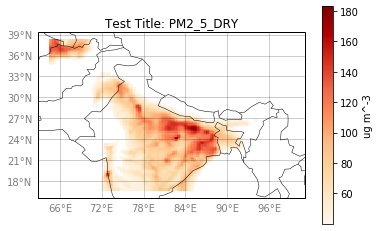

In [115]:
map_2D(ds_avg, 'PM2_5_DRY', title='Test Title: PM2_5_DRY', level=1, mask_values=40, pixels=True, save='/exports/csce/datastore/geos/users/s1878599/2D_map_test', format='png')

In [10]:
import chart_studio.plotly as py
import plotly.graph_objs as go

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_rev = x[::-1]

# Line 1
y1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1_upper = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y1_lower = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y1_lower = y1_lower[::-1]

# Line 2
y2 = [5, 2.5, 5, 7.5, 5, 2.5, 7.5, 4.5, 5.5, 5]
y2_upper = [5.5, 3, 5.5, 8, 6, 3, 8, 5, 6, 5.5]
y2_lower = [4.5, 2, 4.4, 7, 4, 2, 7, 4, 5, 4.75]
y2_lower = y2_lower[::-1]

# Line 3
y3 = [10, 8, 6, 4, 2, 0, 2, 4, 2, 0]
y3_upper = [11, 9, 7, 5, 3, 1, 3, 5, 3, 1]
y3_lower = [9, 7, 5, 3, 1, -.5, 1, 3, 1, -1]
y3_lower = y3_lower[::-1]

trace1 = go.Scatter(
    x=x,
    y=y1_upper+y1_lower,
    fill='tozerox',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Fair',
)
trace2 = go.Scatter(
    x=x+x_rev,
    y=y2_upper+y2_lower,
    fill='tozerox',
    fillcolor='rgba(0,176,246,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Premium',
    showlegend=False,
)
trace3 = go.Scatter(
    x=x+x_rev,
    y=y3_upper+y3_lower,
    fill='tozerox',
    fillcolor='rgba(231,107,243,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Fair',
)
trace4 = go.Scatter(
    x=x,
    y=y1,
    line=dict(color='rgb(0,100,80)'),
    mode='lines',
    name='Fair',
)
trace5 = go.Scatter(
    x=x,
    y=y2,
    line=dict(color='rgb(0,176,246)'),
    mode='lines',
    name='Premium',
)
trace6 = go.Scatter(
    x=x,
    y=y3,
    line=dict(color='rgb(231,107,243)'),
    mode='lines',
    name='Ideal',
)

data = [trace1, trace4] # trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    paper_bgcolor='rgb(255,255,255)',
    plot_bgcolor='rgb(229,229,229)',
    xaxis=dict(
        gridcolor='rgb(255,255,255)',
        range=[1,10],
        showgrid=True,
        showline=False,
        showticklabels=True,
        tickcolor='rgb(127,127,127)',
        ticks='outside',
        zeroline=False
    ),
    yaxis=dict(
        gridcolor='rgb(255,255,255)',
        showgrid=True,
        showline=False,
        showticklabels=True,
        tickcolor='rgb(127,127,127)',
        ticks='outside',
        zeroline=False
    ),
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [6]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_rev = x[::-1]

In [7]:
x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [8]:
x_rev

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [11]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import pandas as pd

def line_plot(dates, *args, error_line=False):


    trace = go.Scatter(
    name='Measurement',
    x=dates, 
    y= da[1,:].values,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty')

    data = [trace]

    if error_line:
        upper_bound = go.Scatter(
        name='Upper Bound',
        x=dates, 
        y= (da[1,:].values + da_error[1,:].values),
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

        lower_bound = go.Scatter(
        name='Lower Bound',
        x=dates, 
        y= (da[1,:].values -da_error[1,:].values),
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')
    
        data = [lower_bound, trace, upper_bound]
       
        
    layout = go.Layout(
    yaxis=dict(title='Wind direction (deg from N)'),
    title='Average wind direction over Time',
    showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    fig.show()

NameError: name 'wind_mean' is not defined